<a href="https://colab.research.google.com/github/btknzn/NaturalLanguageProcessing/blob/main/batuproje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-sa21r4dt
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-sa21r4dt
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
cd /content/drive/MyDrive/assignment2

/content/drive/MyDrive/assignment2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers.csv_logs import CSVLogger
from torch.nn import functional as F
from pytorch_lightning.loggers import NeptuneLogger
import torchmetrics.functional as FM

from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.base import Callback
import tensorboard
from pytorch_lightning.callbacks import ModelCheckpoint


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers.csv_logs import CSVLogger
from torch.nn import functional as F
from pytorch_lightning.loggers import NeptuneLogger
import torchmetrics.functional as FM

from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.base import Callback


In [ ]:
import numpy as np
import random
import json
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import glob

from tqdm.notebook import tqdm

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic=True 

In [ ]:
meta = json.load(open('./meta.json', 'r'))
tokens = meta['tokens']
num_token = len(tokens)
num_user = meta['num_user']

In [ ]:
train_data = json.load(open('./train.json', 'r'))
valid_data = json.load(open('./valid.json', 'r'))
s_idx = 0

In [ ]:
train_datas =  []
valid_datas =  []
max_len = 0

for i in range (len(train_data)):
     train_datas.append(train_data[i])
     max_len = max(len(train_data[i]['token_id']), max_len)
     
    
for i in range (len(valid_data)):
     valid_datas.append(valid_data[i])
     max_len = max(len(train_data[i]['token_id']), max_len)
     
     
print(max_len)


60


In [ ]:
class tweetDataset(Dataset):
    def __init__(self, data,max_len):
        self.data = data
        self.number_of_tokens = 13369
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        padding_name = [self.number_of_tokens-1 for _ in range(self.max_len)]
        sample = self.data[idx]
        curr_name =  sample["token_id"]
        padding_name[:len(curr_name)] = curr_name
        sample = self.data[idx]
        sample['token_id'] = torch.LongTensor(padding_name[:-1])
        return sample

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, num_token, num_user, embed_dim, rnn_dim, num_layers, dropout, batch_size=256, lr =1e-5):
        super(Model, self).__init__()
        self.save_hyperparameters()
        self.num_token = num_token
        self.num_user = num_user
        self.embed_dim = embed_dim
        self.rnn_dim = rnn_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_token, embed_dim)
        self.rnn = nn.LSTM(embed_dim, rnn_dim, num_layers=num_layers, batch_first=True,bidirectional = True)
        self.out_linear = nn.Linear(rnn_dim*2, num_user)
        self.dropout = nn.Dropout(0.3)
        self.batch_size = batch_size
        self.learning_rate = lr


    def forward(self, token_id):
        embed = self.embedding(token_id)
        # embed = self.dropout(embed)
        embed = self.dropout(embed)
        out, _ = self.rnn(embed)
        return self.out_linear(out[:, -1])

    def training_step (self,train_batch,batch_idx):
        x= train_batch['token_id']
        y = train_batch['user_id']
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y)
        train_accuracy_b = FM.accuracy(y_pred, y)
        self.log("train_loss",loss)
        self.log("train_acc",train_accuracy_b )
        return {'loss' : loss, 'y_pred' : y_pred, 'y_true' : y}
      
    def validation_step(self, val_batch, batch_idx):
        x = val_batch['token_id']
        y = val_batch['user_id']
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y)
        val_accuracy_b = FM.accuracy(y_pred, y)
        self.log("valid_loss",loss)
        self.log("valid_acc",val_accuracy_b )
        return {'loss' : loss, 'y_pred' : y_pred, 'y_true' : y}

    def test_step(self, test_batch, batch_idx):
        x = test_batch['token_id']
        y = test_batch['user_id']
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y)
        test_accuracy_b = FM.accuracy(y_pred, y)
        self.log("valid_loss",loss)
        self.log("valid_acc",test_accuracy_b )
        return {'loss' : loss, 'y_pred' : y_pred, 'y_true' : y}
    
    def configure_optimizers(self):
        lr = self.learning_rate
        return optim.Adam(model.parameters(), lr= self.learning_rate, weight_decay=1e-9)
    
    def train_dataloader(self):
        train_dataset = tweetDataset(train_datas,max_len)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True,num_workers=4)
        return train_dataloader

    def val_dataloader(self):
        valid_dataset = tweetDataset(valid_datas,max_len)
        valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=True,num_workers=4)
        return valid_dataloader

    def test_dataloader(self):
        test_dataset = tweetDataset(valid_datas, max_len)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size,shuffle = True, num_workers=4)
        return test_dataloader

    #def training_epoch(self, outputs):
      #self.log('Train_acc_epoch', accuracy, prog_bar=True)

    
    
    
    
 

In [ ]:
model = Model(num_token, num_user, embed_dim=512, rnn_dim=1024, dropout = 0.3 ,num_layers=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:542: PossibleUserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 100. To avoid any miscalculations, use `sel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/drive/MyDrive/assignment2/.lr_find_4ad92857-88e3-4d27-903c-9eefec74c744.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1646: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  "Be aware that when using `ckpt_path`,"


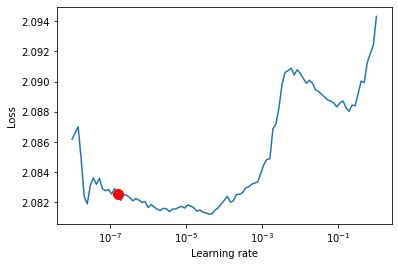

In [ ]:
trainer = Trainer(gpus=1,max_epochs = 1000)

lr_finder = trainer.tuner.lr_find(model)

# # Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# # update hparams of the model
model.hparams.lr = new_lr

In [ ]:
new_lr

1.5848931924611133e-07

In [ ]:
num_param = sum(p.numel() for p in model.parameters())
print('Number of parameters: {}'.format(num_param))
print('[NOTE] Number of parameters SHOULD NOT exceed 20,000,000 (20 million).')

Number of parameters: 19460616
[NOTE] Number of parameters SHOULD NOT exceed 20,000,000 (20 million).


In [ ]:
import tensorboard
from pytorch_lightning.callbacks import ModelCheckpoint
logger = pl_loggers.TensorBoardLogger("/content/drive/MyDrive/logs/")

In [ ]:

logger = pl_loggers.TensorBoardLogger("/content/drive/MyDrive/logs/")


checkpoint_callback = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/logs/",
    monitor="valid_acc",
    filename="best",
    #save_top_k=1,
    every_n_epochs  = 10
)




trainer = pl.Trainer(gpus=1,auto_scale_batch_size ='binsearch' , log_every_n_steps=1, logger=logger, callbacks=[checkpoint_callback], max_epochs = 100000)

torch.cuda.max_memory_allocated(device='cuda')
torch.cuda.empty_cache()


trainer.tune(model)
trainer.fit(model)


In [ ]:
logger.log_graph(model)
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/logs/

In [ ]:
trainer.test(ckpt_path="/content/drive/MyDrive/logs/best.ckpt")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
cd /content/drive/MyDrive/assignment2

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers.csv_logs import CSVLogger
from torch.nn import functional as F
from pytorch_lightning.loggers import NeptuneLogger
import torchmetrics.functional as FM

from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.base import Callback
import numpy as np
import random
import json
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import glob

from tqdm.notebook import tqdm
import tensorboard
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
import tensorboard
from pytorch_lightning.callbacks import ModelCheckpoint
logger = pl_loggers.TensorBoardLogger("/content/drive/MyDrive/logs/")

In [ ]:
meta = json.load(open('./meta.json', 'r'))
tokens = meta['tokens']
num_token = len(tokens)
num_user = meta['num_user']

train_data = json.load(open('./train.json', 'r'))
valid_data = json.load(open('./valid.json', 'r'))
s_idx = 0
train_data = json.load(open('./train.json', 'r'))
valid_data = json.load(open('./valid.json', 'r'))
s_idx = 0

In [ ]:
train_datas =  []
valid_datas =  []
max_len = 0

for i in range (len(train_data)):
     train_datas.append(train_data[i])
     max_len = max(len(train_data[i]['token_id']), max_len)
     
    
for i in range (len(valid_data)):
     valid_datas.append(valid_data[i])
     max_len = max(len(train_data[i]['token_id']), max_len)
     
     
print(max_len)


In [ ]:
class tweetDataset(Dataset):
    def __init__(self, data,max_len):
        self.data = data
        self.number_of_tokens = 13369
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        padding_name = [self.number_of_tokens-1 for _ in range(self.max_len)]
        sample = self.data[idx]
        curr_name =  sample["token_id"]
        padding_name[:len(curr_name)] = curr_name
        sample = self.data[idx]
        sample['token_id'] = torch.LongTensor(padding_name[:-1])
        return sample

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, num_token, num_user, embed_dim, rnn_dim, num_layers, dropout, batch_size=256, lr =1e-5):
        super(Model, self).__init__()
        self.save_hyperparameters()
        self.num_token = num_token
        self.num_user = num_user
        self.embed_dim = embed_dim
        self.rnn_dim = rnn_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_token, embed_dim)
        self.rnn = nn.LSTM(embed_dim, rnn_dim, num_layers=num_layers, batch_first=True,bidirectional = True)
        self.out_linear = nn.Linear(rnn_dim*2, num_user)
        self.dropout = nn.Dropout(0.3)
        self.batch_size = batch_size
        self.learning_rate = lr


    def forward(self, token_id):
        embed = self.embedding(token_id)
        # embed = self.dropout(embed)
        embed = self.dropout(embed)
        out, _ = self.rnn(embed)
        return self.out_linear(out[:, -1])

    def training_step (self,train_batch,batch_idx):
        x= train_batch['token_id']
        y = train_batch['user_id']
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y)
        train_accuracy_b = FM.accuracy(y_pred, y)
        self.log("train_loss",loss)
        self.log("train_acc",train_accuracy_b )
        return {'loss' : loss, 'y_pred' : y_pred, 'y_true' : y}
      
    def validation_step(self, val_batch, batch_idx):
        x = val_batch['token_id']
        y = val_batch['user_id']
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y)
        val_accuracy_b = FM.accuracy(y_pred, y)
        self.log("valid_loss",loss)
        self.log("valid_acc",val_accuracy_b )
        return {'loss' : loss, 'y_pred' : y_pred, 'y_true' : y}

    def test_step(self, test_batch, batch_idx):
        x = test_batch['token_id']
        y = test_batch['user_id']
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y)
        test_accuracy_b = FM.accuracy(y_pred, y)
        self.log("valid_loss",loss)
        self.log("valid_acc",test_accuracy_b )
        return {'loss' : loss, 'y_pred' : y_pred, 'y_true' : y}
    
    def configure_optimizers(self):
        lr = self.learning_rate
        return optim.Adam(model.parameters(), lr= self.learning_rate, weight_decay=1e-9)
    
    def train_dataloader(self):
        train_dataset = tweetDataset(train_datas,max_len)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True,num_workers=4)
        return train_dataloader

    def val_dataloader(self):
        valid_dataset = tweetDataset(valid_datas,max_len)
        valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=True,num_workers=4)
        return valid_dataloader

    def test_dataloader(self):
        test_dataset = tweetDataset(valid_datas, max_len)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size,shuffle = True, num_workers=4)
        return test_dataloader

    #def training_epoch(self, outputs):
      #self.log('Train_acc_epoch', accuracy, prog_bar=True)

    
    
    
    
 

In [ ]:



logger = pl_loggers.TensorBoardLogger("/content/drive/MyDrive/logs/")


checkpoint_callback = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/logs/",
    monitor="valid_acc",
    filename="best_repeat1",
    #save_top_k=1,
    every_n_epochs  = 10
)
batch_size = 256
dropout= 0.3
embed_dim= 512
lr= 1.0e-05
num_layers= 1
num_token= 13369
num_user= 8
rnn_dim=1024

model = Model(num_token, num_user, embed_dim=512, rnn_dim=1024, dropout = 0.3 , num_layers=1  , batch_size =batch_size ,lr =lr)
model = Model.load_from_checkpoint("/content/drive/MyDrive/logs/best.ckpt")

trainer = pl.Trainer(gpus=1 , log_every_n_steps=1, logger=logger, callbacks=[checkpoint_callback], max_epochs = 100000)
trainer.fit(model)